# Question 2

Use deep learning to perform image classification according to the CC-D-Y modelling strategy. Specifically, you must:
1. Discuss why convolutional neural networks (CNNs) could be an appropriate type of model architecture to use for this task.
2. Train a CNN to solve the problem. Here, you must explicitly:
a. Discuss different optimization methods and motivate your choice.
b. Visualize how regularization (such as dropout, weight regularization, or early
stopping) impacts the training of your model. Here, be sure to visualize plots of train and validation losses and accuracies both with and without the use of regularization. Discuss regularization and its relation to overfitting.
c. Visualize how data augmentation impacts the training of your model. Here, be sure to visualize
plots of train and validation losses and accuracies both with and without the use of data augmentation. Discuss data augmentation and its relation to overfitting.
d. Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.
3. Having run the experiments above, select your preferred model (motivate why it is your preferred model). Calculate and report its performance on the test data.

## Hints

### CC-D-Y model strategy
Use three seperate classification models:
- ModelCC - Century - binary "18" or not
- ModelD - Decade - 11 classes (0-10), 10 being the residual class
- ModelY - year - 11 classes (0-10), 10 being the residual class

Some observations are not depicting year-strings and some only contains parts of complete year-string. These images might need special attention when preparing data (this is where residual class comes in handy).

### Preparation of data
For all questions in the exam, be sure to state how and why you prepare the data, including considerations for how to split the data, scale the data, and reshape the data (if you do not perform one or more steps it must be motivated). If you use the same method for multiple questions, it is sufficient to describe the procedure once and refer to it in subsequent questions (however, it must still be motivated).

### Evaluation
When evaluating and comparing the accuracy of the different CC-D-Y models please consider using also the following metrics:
- "Sequence" accuracy: A prediction is recorded as correct (earning 1 point) only if all three sub models in the CC-D-Y model are making correct predictions.
- "Character" accuracy: A prediction is recorded as 1/3 correct (earning 1/3 point) if only one of the three sub models in the CC-D-Y model is making a correct prediction. Similarly, the prediction is recorded as 2/3 correct (earning 2/3 point) if two of the sub models in the CC- D-Y model are making correct predictions. If all three sub models are correct the prediction of the CC-D-Y model is recorded as correct (earning 1 point).



## Setup

In [119]:
# Imports
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from sklearn.model_selection import train_test_split
import splitfolders
import matplotlib.pyplot as plt
import numpy as np

%cd /Users/steffenrask/OneDrive - Syddansk Universitet/Data Science/DS807 - Anvendt maskinlæring/Exam

/Users/steffenrask/OneDrive - Syddansk Universitet/Data Science/DS807 - Anvendt maskinlæring/Exam


### Label preparation

In [70]:
# Load labels
df = pd.read_csv("DIDA_12000_String_Digit_Labels.csv", names=["Index","Label"])

# Create new labels for CC-D-Y models
# 18 century (0) or not (1)
def label_CC(label):

    x = str(label)   
    if len(x) == 4:
        if x[0] == "1" and x[1] == "8":
            return str(0)
        else:
            return str(1)
    return str(1)

# Decade or residual (10)
def label_D(label):

    x = str(label)
    if len(x) != 4:
        return str(10)
    else:
        return str(x[2])  

# Year or residual (10)
def label_Y(label):

    x = str(label)
    if len(x) != 4:
        return str(10)
    else:
        return str(x[3]) 
    
def filename(index):
   return str(index) + '.jpg'
    

df["CC"]=df["Label"].apply(label_CC)
df["D"]=df["Label"].apply(label_D)
df["Y"]=df["Label"].apply(label_Y)
df["Filename"]=df["Index"].apply(filename)

# Check the ratio of samples in each class:
print(df["CC"].value_counts()) # how many are there in each category
print(df["D"].value_counts()) # how many are there in each category
print(df["Y"].value_counts()) # how many are there in each category


0    11611
1      389
Name: CC, dtype: int64
2     3071
3     2918
1     2804
0     2493
4      371
10     305
9       27
7        6
5        3
8        1
6        1
Name: D, dtype: int64
0     1402
6     1244
5     1206
1     1163
9     1152
7     1136
3     1120
8     1100
4     1100
2     1072
10     305
Name: Y, dtype: int64


In [71]:
print(df)

       Index  Label CC  D  Y   Filename
0          1   1836  0  3  6      1.jpg
1          2   1836  0  3  6      2.jpg
2          3   1840  0  4  0      3.jpg
3          4   1840  0  4  0      4.jpg
4          5   1823  0  2  3      5.jpg
...      ...    ... .. .. ..        ...
11995  11996   1808  0  0  8  11996.jpg
11996  11997   1809  0  0  9  11997.jpg
11997  11998   1840  0  4  0  11998.jpg
11998  11999   1840  0  4  0  11999.jpg
11999  12000   1810  0  1  0  12000.jpg

[12000 rows x 6 columns]


### Split data

In [13]:
# Split data into train, validation and test sets.
# Ratio of 70, 20, 10.

splitfolders.ratio("./DIDA_12000_String_Digit_Images", output= "./DIDA_12000_String_Digit_Images/DIDA_1/" + 'cell_image', 
                   seed=42, ratio=(.7, .2, .1), 
                   group_prefix=None)

Copying files: 12000 files [00:12, 993.75 files/s] 


### Exploratory data analysis

(81, 192, 3)


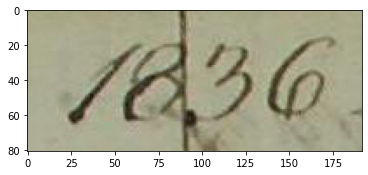

In [215]:
### Input image 

from matplotlib.pyplot import imshow

path=r'./DIDA_12000_String_Digit_Images/DIDA_1/1.jpg'
img=plt.imread(path)
print (img.shape)
imshow(img)

# ModelCC

### Data generation for ModelCC

In [72]:
# Datageneration for ModelCC

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

datagen=ImageDataGenerator(
    rescale=1./255.,
    rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
    )

datagen_test=ImageDataGenerator(rescale=1./255.)

train_generator_CC=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(32,64)) #Do we need to resize?

valid_generator_CC=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=32,
seed=42,
shuffle=True,
class_mode="binary",
target_size=(32,64))

test_generator_CC=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="CC",
batch_size=32,
seed=42,
shuffle=False,
class_mode="binary",
target_size=(32,64))



/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3600 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 9600 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


Found 8400 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 1200 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 10800 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


### Build model

In [177]:
# Build ModelCC - first try

modelCC = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid'), #Neuron = number of classes
    ])

modelCC.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelCC.summary()

modelCC.save('modelCC')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 384)             

In [165]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

history = modelCC.fit_generator(generator=train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80
)

modelCC.save('modelCC_fitted')

Epoch 1/80
262/262 [==============================] - 27s 99ms/step - loss: 0.1724 - accuracy: 0.9671 - val_loss: 0.1477 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 24s 92ms/step - loss: 0.1530 - accuracy: 0.9677 - val_loss: 0.1354 - val_accuracy: 0.9704
Epoch 3/80
262/262 [==============================] - 26s 97ms/step - loss: 0.1471 - accuracy: 0.9674 - val_loss: 0.1258 - val_accuracy: 0.9704
Epoch 4/80
262/262 [==============================] - 25s 97ms/step - loss: 0.1269 - accuracy: 0.9681 - val_loss: 0.0892 - val_accuracy: 0.9775
Epoch 5/80
262/262 [==============================] - 26s 99ms/step - loss: 0.1108 - accuracy: 0.9699 - val_loss: 0.0859 - val_accuracy: 0.9775
Epoch 6/80
262/262 [==============================] - 26s 98ms/step - loss: 0.0999 - accuracy: 0.9719 - val_loss: 0.0664 - val_accuracy: 0.9833
Epoch 7/80
262/262 [==============================] - 26s 97ms/step - loss: 0.0892 - accuracy: 0.9749 - val_loss: 0.0942 - val_accuracy:

262/262 [==============================] - 37s 140ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.0375 - val_accuracy: 0.9925
Epoch 58/80
262/262 [==============================] - 39s 150ms/step - loss: 0.0262 - accuracy: 0.9913 - val_loss: 0.0292 - val_accuracy: 0.9896
Epoch 59/80
262/262 [==============================] - 28s 106ms/step - loss: 0.0240 - accuracy: 0.9918 - val_loss: 0.0380 - val_accuracy: 0.9925
Epoch 60/80
262/262 [==============================] - 27s 103ms/step - loss: 0.0224 - accuracy: 0.9931 - val_loss: 0.0351 - val_accuracy: 0.9933
Epoch 61/80
262/262 [==============================] - 33s 127ms/step - loss: 0.0227 - accuracy: 0.9921 - val_loss: 0.0275 - val_accuracy: 0.9929
Epoch 62/80
262/262 [==============================] - 36s 136ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0344 - val_accuracy: 0.9883
Epoch 63/80
262/262 [==============================] - 35s 134ms/step - loss: 0.0209 - accuracy: 0.9924 - val_loss: 0.0336 - val_accurac

In [78]:
# Build model - second try with 10 layers

model10 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    ])

model10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
model10.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 30, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 30, 16)       

In [79]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

history10 = model10.fit_generator(generator=train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
)

Epoch 1/10
262/262 [==============================] - 34s 125ms/step - loss: 0.2415 - accuracy: 0.9636 - val_loss: 0.1440 - val_accuracy: 0.9704
Epoch 2/10
262/262 [==============================] - 32s 122ms/step - loss: 0.1623 - accuracy: 0.9674 - val_loss: 0.1399 - val_accuracy: 0.9704
Epoch 3/10
262/262 [==============================] - 33s 124ms/step - loss: 0.1507 - accuracy: 0.9675 - val_loss: 0.1323 - val_accuracy: 0.9704
Epoch 4/10
262/262 [==============================] - 32s 122ms/step - loss: 0.1497 - accuracy: 0.9674 - val_loss: 0.1325 - val_accuracy: 0.9704
Epoch 5/10
262/262 [==============================] - 34s 129ms/step - loss: 0.1469 - accuracy: 0.9676 - val_loss: 0.1515 - val_accuracy: 0.9704
Epoch 6/10
262/262 [==============================] - 35s 133ms/step - loss: 0.1443 - accuracy: 0.9675 - val_loss: 0.1350 - val_accuracy: 0.9704
Epoch 7/10
262/262 [==============================] - 35s 132ms/step - loss: 0.1472 - accuracy: 0.9676 - val_loss: 0.1274 - val_ac

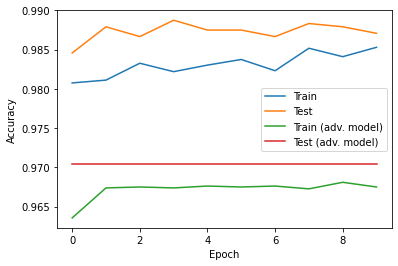

In [82]:
# Comparing models:

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label = 'Test')
plt.plot(history10.history['accuracy'], label = 'Train (adv. model)')
plt.plot(history10.history['val_accuracy'], label = 'Test (adv. model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

### Try alternative shallow model

In [139]:
# Optimize modelCC with - did not improve
modelCC_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid'), #Neuron = number of classes
    ])

modelCC_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy', # used when labels are ints and not one-hot encoded
    metrics=['accuracy'],
    )
modelCC_2.summary()


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_117 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 13, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 6, 14, 32)         0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 4, 12, 32)         9248      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 384)             

In [140]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

history1 = modelCC_2.fit_generator(generator=train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80
)

Epoch 1/80
262/262 [==============================] - 26s 97ms/step - loss: 0.1617 - accuracy: 0.9674 - val_loss: 0.1364 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 25s 94ms/step - loss: 0.1486 - accuracy: 0.9675 - val_loss: 0.1283 - val_accuracy: 0.9704
Epoch 3/80
262/262 [==============================] - 25s 96ms/step - loss: 0.1334 - accuracy: 0.9674 - val_loss: 0.1084 - val_accuracy: 0.9717
Epoch 4/80
262/262 [==============================] - 23s 89ms/step - loss: 0.1080 - accuracy: 0.9720 - val_loss: 0.0684 - val_accuracy: 0.9808
Epoch 5/80
262/262 [==============================] - 23s 86ms/step - loss: 0.0920 - accuracy: 0.9756 - val_loss: 0.0646 - val_accuracy: 0.9842
Epoch 6/80
262/262 [==============================] - 26s 98ms/step - loss: 0.0835 - accuracy: 0.9767 - val_loss: 0.0583 - val_accuracy: 0.9854
Epoch 7/80
262/262 [==============================] - 25s 94ms/step - loss: 0.0884 - accuracy: 0.9771 - val_loss: 0.0683 - val_accuracy:

262/262 [==============================] - 24s 92ms/step - loss: 0.0252 - accuracy: 0.9934 - val_loss: 0.0320 - val_accuracy: 0.9912
Epoch 58/80
262/262 [==============================] - 24s 92ms/step - loss: 0.0277 - accuracy: 0.9897 - val_loss: 0.0323 - val_accuracy: 0.9908
Epoch 59/80
262/262 [==============================] - 24s 91ms/step - loss: 0.0327 - accuracy: 0.9886 - val_loss: 0.0323 - val_accuracy: 0.9904
Epoch 60/80
262/262 [==============================] - 22s 82ms/step - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.0294 - val_accuracy: 0.9917
Epoch 61/80
262/262 [==============================] - 23s 87ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.0350 - val_accuracy: 0.9908
Epoch 62/80
262/262 [==============================] - 24s 91ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0282 - val_accuracy: 0.9908
Epoch 63/80
262/262 [==============================] - 22s 84ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0267 - val_accuracy: 0.99

### Compare models

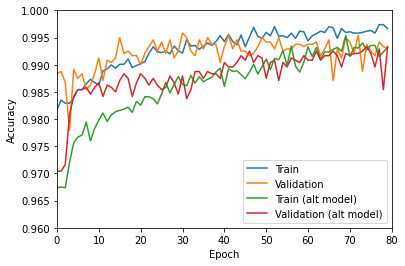

In [148]:
# Comparing accuracy:

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.plot(history1.history['accuracy'], label = 'Train (alt model)')
plt.plot(history1.history['val_accuracy'], label = 'Validation (alt model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.96, 1.0])
plt.xlim([0,80])
plt.legend()


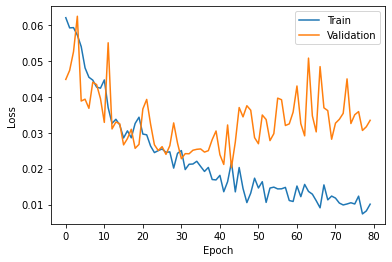

In [153]:
# Comparing loss

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(history1.history['loss'], label = 'Train (alt model)')
#plt.plot(history1.history['val_loss'], label = 'Validation (alt model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

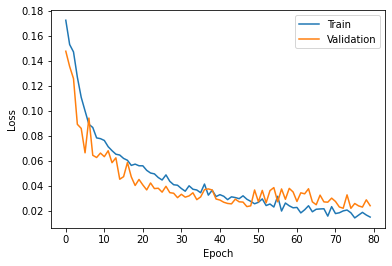

In [170]:
# Comparing loss - anden gang jeg trænede

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
#plt.plot(history1.history['loss'], label = 'Train (alt model)')
#plt.plot(history1.history['val_loss'], label = 'Validation (alt model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [167]:
modelCC.evaluate_generator(generator=valid_generator_CC,
steps=STEP_SIZE_TEST)

[0.019533604383468628, 0.9949324131011963]

### Optimize first try model

In [178]:
modelCC.evaluate_generator(generator=valid_generator_CC,
steps=STEP_SIZE_TEST)

[0.6833174824714661, 0.7896959185600281]

In [179]:
# Early stopping to achieve best parameter settings
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

callback = []
callback.append(reduce_lr)
callback.append(early_stopping)

# This callback will stop the training when there is no improvement in the loss for 5 consecutive epochs.

STEP_SIZE_TRAIN=train_generator_CC.n//train_generator_CC.batch_size
STEP_SIZE_VALID=valid_generator_CC.n//valid_generator_CC.batch_size
STEP_SIZE_TEST=test_generator_CC.n//test_generator_CC.batch_size

history_reg = modelCC.fit_generator(generator=train_generator_CC,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_CC,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=80,
                    callbacks=[callback]
)

len(history_reg.history['loss'])


Epoch 1/80
262/262 [==============================] - 97s 360ms/step - loss: 0.1664 - accuracy: 0.9665 - val_loss: 0.1411 - val_accuracy: 0.9704
Epoch 2/80
262/262 [==============================] - 39s 149ms/step - loss: 0.1487 - accuracy: 0.9674 - val_loss: 0.1322 - val_accuracy: 0.9704
Epoch 3/80
262/262 [==============================] - 38s 145ms/step - loss: 0.1410 - accuracy: 0.9676 - val_loss: 0.1165 - val_accuracy: 0.9704
Epoch 4/80
262/262 [==============================] - 38s 146ms/step - loss: 0.1247 - accuracy: 0.9682 - val_loss: 0.0873 - val_accuracy: 0.9767
Epoch 5/80
262/262 [==============================] - 36s 137ms/step - loss: 0.0924 - accuracy: 0.9734 - val_loss: 0.0698 - val_accuracy: 0.9804
Epoch 6/80
262/262 [==============================] - 33s 127ms/step - loss: 0.0828 - accuracy: 0.9768 - val_loss: 0.0567 - val_accuracy: 0.9862
Epoch 7/80
262/262 [==============================] - 53s 203ms/step - loss: 0.0846 - accuracy: 0.9787 - val_loss: 0.0606 - val_ac

50

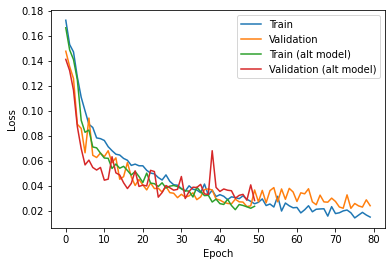

In [180]:
# Comparing loss

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.plot(history_reg.history['loss'], label = 'Train (alt model)')
plt.plot(history_reg.history['val_loss'], label = 'Validation (alt model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [181]:
modelCC.evaluate_generator(generator=valid_generator_CC,
steps=STEP_SIZE_TEST)

[0.0405096635222435, 0.9923986196517944]

# ModelD

### Data generation for ModelD

In [224]:
# Datageneration for ModelD

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_generator_D=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64))

valid_generator_D=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64))

test_generator_D=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="D",
batch_size=32,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(32,64))


/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3600 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


Found 8400 validated image filenames belonging to 11 classes.


/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 9600 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


Found 2400 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 10800 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


### Build model

In [243]:
# Build ModelD - first try with shallow model similar to ModelCC

modelD = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'), # softmax for multiple classes
    ])

modelD.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelD.summary()

modelD.save('modelD')


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_216 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_160 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 384)             

In [244]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_D.n//train_generator_D.batch_size
STEP_SIZE_VALID=valid_generator_D.n//valid_generator_D.batch_size
STEP_SIZE_TEST=test_generator_D.n//test_generator_D.batch_size

historyD = modelD.fit_generator(generator=train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)


/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
262/262 [==============================] - 52s 186ms/step - loss: 1.6340 - accuracy: 0.0191 - val_loss: 1.5683 - val_accuracy: 0.0021
Epoch 2/20
262/262 [==============================] - 39s 147ms/step - loss: 1.5970 - accuracy: 0.0759 - val_loss: 1.5595 - val_accuracy: 0.2163
Epoch 3/20
262/262 [==============================] - 37s 139ms/step - loss: 1.5350 - accuracy: 0.1426 - val_loss: 1.4169 - val_accuracy: 0.1183
Epoch 4/20
262/262 [==============================] - 33s 126ms/step - loss: 1.3805 - accuracy: 0.1871 - val_loss: 1.2481 - val_accuracy: 0.4075
Epoch 5/20
262/262 [==============================] - 36s 135ms/step - loss: 1.1830 - accuracy: 0.2102 - val_loss: 0.9898 - val_accuracy: 0.1846
Epoch 6/20
262/262 [==============================] - 43s 164ms/step - loss: 1.0269 - accuracy: 0.1954 - val_loss: 0.8682 - val_accuracy: 0.2629
Epoch 7/20
262/262 [==============================] - 39s 147ms/step - loss: 0.9115 - accuracy: 0.1985 - val_loss: 0.7467 - val_ac

In [245]:
modelD.evaluate_generator(generator=valid_generator_D,
steps=STEP_SIZE_TEST)

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.36597612500190735, 0.2314189225435257]

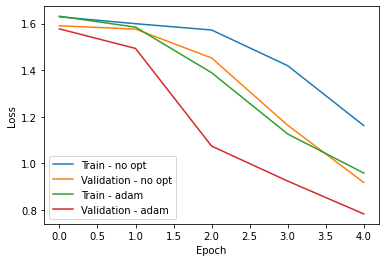

In [208]:
# Compare models - without or with different optimizers

plt.plot(historyD1.history['loss'], label='Train - no opt')
plt.plot(historyD1.history['val_loss'], label = 'Validation - no opt')
plt.plot(historyD2.history['loss'], label = 'Train - adam')
plt.plot(historyD2.history['val_loss'], label = 'Validation - adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

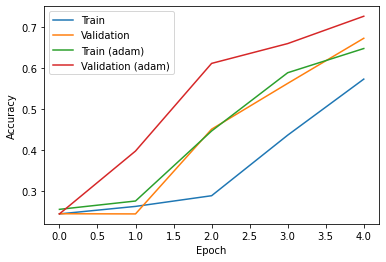

In [209]:
# Comparing accuracy:

plt.plot(historyD1.history['accuracy'], label='Train')
plt.plot(historyD1.history['val_accuracy'], label = 'Validation')
plt.plot(historyD2.history['accuracy'], label = 'Train (adam)')
plt.plot(historyD2.history['val_accuracy'], label = 'Validation (adam)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


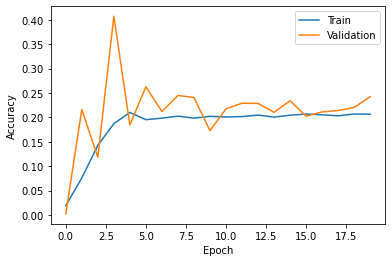

In [246]:
# Comparing accuracy:

plt.plot(historyD.history['accuracy'], label='Train')
plt.plot(historyD.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


#### Second try: deeper model

In [247]:
# Build model - second try with 10 layers

modelD10 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding="same"),
    #tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu',padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

modelD10.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
model10.summary()

modelD10.save('modelD10')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 60, 16)        1216      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 30, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 30, 16)        6416      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 30, 16)       

In [248]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_D.n//train_generator_D.batch_size
STEP_SIZE_VALID=valid_generator_D.n//valid_generator_D.batch_size
STEP_SIZE_TEST=test_generator_D.n//test_generator_D.batch_size

history10 = modelD10.fit_generator(generator=train_generator_D,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_D,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
262/262 [==============================] - 42s 152ms/step - loss: 1.6692 - accuracy: 0.0944 - val_loss: 1.5713 - val_accuracy: 0.0000e+00
Epoch 2/10
262/262 [==============================] - 37s 142ms/step - loss: 1.6014 - accuracy: 0.0797 - val_loss: 1.5682 - val_accuracy: 0.0000e+00
Epoch 3/10
262/262 [==============================] - 37s 141ms/step - loss: 1.5898 - accuracy: 0.0060 - val_loss: 1.5974 - val_accuracy: 0.0000e+00
Epoch 4/10
262/262 [==============================] - 32s 122ms/step - loss: 1.5900 - accuracy: 0.0370 - val_loss: 1.5679 - val_accuracy: 0.0000e+00
Epoch 5/10
262/262 [==============================] - 35s 135ms/step - loss: 1.5915 - accuracy: 0.0011 - val_loss: 1.5752 - val_accuracy: 0.0000e+00
Epoch 6/10
 73/262 [=======>......................] - ETA: 23s - loss: 1.5677 - accuracy: 0.0000e+00

KeyboardInterrupt: 

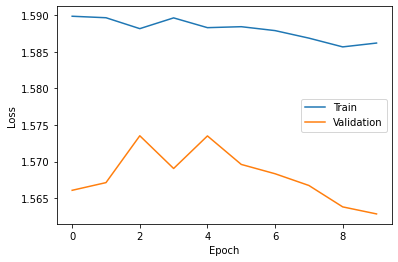

In [241]:
plt.plot(history10.history['loss'], label='Train')
plt.plot(history10.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

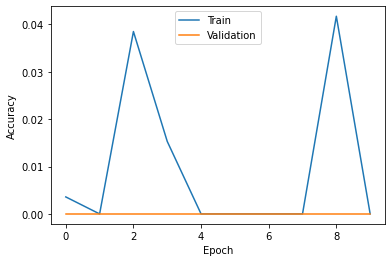

In [242]:
plt.plot(history10.history['accuracy'], label='Train')
plt.plot(history10.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### ModelY

In [371]:
# Datageneration for ModelY

# Se https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

train_generator_Y=datagen.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/train/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64)
)

valid_generator_Y=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/val/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=32,
seed=42,
shuffle=True,
class_mode="sparse",
target_size=(32,64)
)

test_generator_Y=datagen_test.flow_from_dataframe(
dataframe=df,
directory="./DIDA_12000_String_Digit_Images/cell_image/test/DIDA_1",
x_col="Filename",
y_col="Y",
batch_size=32,
seed=42,
shuffle=False,
class_mode="sparse",
target_size=(32,64)
)

Found 8400 validated image filenames belonging to 11 classes.
Found 2400 validated image filenames belonging to 11 classes.
Found 1200 validated image filenames belonging to 11 classes.


In [341]:
# Build ModelY - first try with shallow model similar to ModelCC

modelY = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'), # softmax for multiple classes
    ])

modelY.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelY.summary()

modelY.save('modelY')


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_262 (Conv2D)          (None, 30, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_193 (MaxPoolin (None, 15, 31, 64)        0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 13, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_194 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_264 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
max_pooling2d_195 (MaxPoolin (None, 2, 6, 32)          0         
_________________________________________________________________
flatten_66 (Flatten)         (None, 384)             

In [342]:
# Fit the model

early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

STEP_SIZE_TRAIN=train_generator_Y.n//train_generator_Y.batch_size
STEP_SIZE_VALID=valid_generator_Y.n//valid_generator_Y.batch_size
STEP_SIZE_TEST=test_generator_Y.n//test_generator_Y.batch_size

historyY = modelY.fit(train_generator_Y,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_Y,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    callbacks=[early_stop]
)
len(historyY.history['loss'])

Epoch 1/20
262/262 [==============================] - 71s 253ms/step - loss: 2.3707 - accuracy: 0.6464 - val_loss: 2.3795 - val_accuracy: 1.0000
Epoch 2/20
262/262 [==============================] - 46s 176ms/step - loss: 2.3608 - accuracy: 0.7962 - val_loss: 2.3473 - val_accuracy: 0.1550
Epoch 3/20
262/262 [==============================] - 45s 173ms/step - loss: 2.2366 - accuracy: 0.2134 - val_loss: 2.0996 - val_accuracy: 0.3517
Epoch 4/20
262/262 [==============================] - 53s 203ms/step - loss: 1.8594 - accuracy: 0.1557 - val_loss: 1.7300 - val_accuracy: 0.1425
Epoch 5/20
262/262 [==============================] - 37s 142ms/step - loss: 1.5474 - accuracy: 0.1422 - val_loss: 1.3940 - val_accuracy: 0.1079
Epoch 6/20
262/262 [==============================] - 166s 635ms/step - loss: 1.3533 - accuracy: 0.1202 - val_loss: 1.2238 - val_accuracy: 0.1412


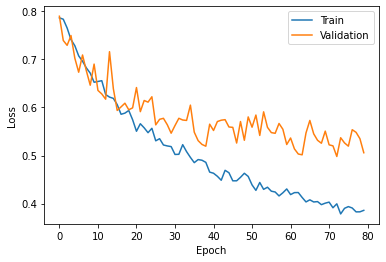

In [255]:
plt.plot(historyY.history['loss'], label='Train')
plt.plot(historyY.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

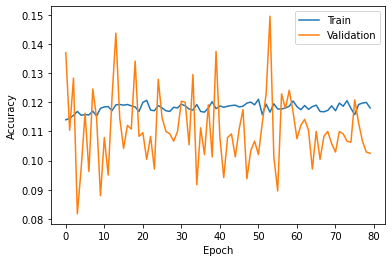

In [256]:
plt.plot(historyY.history['accuracy'], label='Train')
plt.plot(historyY.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [268]:
modelY.evaluate_generator(generator=valid_generator_D,
steps=STEP_SIZE_TEST)

[9.195712089538574, 0.10388513654470444]

In [336]:
modelY.evaluate_generator(generator=test_generator_D,
steps=STEP_SIZE_TEST)

[9.394926071166992, 0.12584459781646729]

In [358]:
modelY_alt = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 64, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'), # softmax for multiple classes
    ])

modelY_alt.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
modelY_alt.summary()

modelY_alt.save('model_alt')


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_292 (Conv2D)          (None, 30, 62, 32)        896       
_________________________________________________________________
max_pooling2d_217 (MaxPoolin (None, 15, 31, 32)        0         
_________________________________________________________________
conv2d_293 (Conv2D)          (None, 13, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 6, 14, 64)         0         
_________________________________________________________________
conv2d_294 (Conv2D)          (None, 4, 12, 32)         18464     
_________________________________________________________________
conv2d_295 (Conv2D)          (None, 2, 10, 32)         9248      
_________________________________________________________________
max_pooling2d_219 (MaxPoolin (None, 1, 5, 32)        

In [372]:
#Callbacks
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

# Fit the model

STEP_SIZE_TRAIN=train_generator_Y.n//train_generator_Y.batch_size
STEP_SIZE_VALID=valid_generator_Y.n//valid_generator_Y.batch_size
STEP_SIZE_TEST=test_generator_Y.n//test_generator_Y.batch_size

historyY_alt = modelY_alt.fit(train_generator_Y,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_Y,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50
                    #callbacks=[early_stop]
)
len(historyY_alt.history['loss'])

Epoch 1/50
 72/262 [=======>......................] - ETA: 25s - loss: 0.4238 - accuracy: 0.1224

KeyboardInterrupt: 

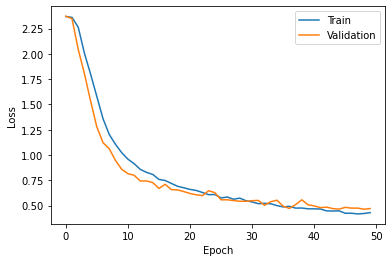

In [360]:
plt.plot(historyY_alt.history['loss'], label='Train')
plt.plot(historyY_alt.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

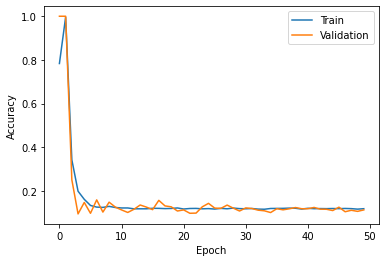

In [361]:
plt.plot(historyY_alt.history['accuracy'], label='Train')
plt.plot(historyY_alt.history['val_accuracy'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [362]:
modelY_alt.evaluate(valid_generator_D,
steps=STEP_SIZE_TEST)

37/37 [==============================] - 2s 40ms/step - loss: 7.3004 - accuracy: 0.1301


[7.300444602966309, 0.13006757199764252]

## Transfer learning

In [379]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(63, 127, 3), # refers to the shape we transfer from
    include_top=False, # cut off the head
    weights='imagenet', # pretrained on the ImageNet data
)

base_model.trainable = False

model_tr = tf.keras.models.Sequential([
    base_model, # the pre-trained part
    tf.keras.layers.Flatten(), # flatten before fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])
model_tr.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )
model_tr.summary()

from tensorflow.keras import layers



TypeError: unsupported operand type(s) for *: 'int' and 'DataFrameIterator'

In [378]:
# Fit the model

STEP_SIZE_TRAIN=train_generator_Y.n//train_generator_Y.batch_size
STEP_SIZE_VALID=valid_generator_Y.n//valid_generator_Y.batch_size
STEP_SIZE_TEST=test_generator_Y.n//test_generator_Y.batch_size

history_tr = model.fit(train_generator_Y,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator_Y,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10


ValueError: in user code:

    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/keras/losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/keras/backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 11) are incompatible
